<a href="https://colab.research.google.com/github/manos-mark/metacovid-siamese-neural-network/blob/main/Siamese_NN_for_MetaCovid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

In this notebook, we are going to use pre-trained networks to solve covid diagnosis challenge. Specifically, we will use a network trained on [ImageNet](http://www.image-net.org/). ImageNet is a massive dataset with over 1 million labeled images in 1,000 categories.

These pre-trained models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called **Transfer Learning**. Here we'll use transfer learning to train a network that can classify our covid, non-covid and pneumonia classes.

## Import Resources

In [85]:
import warnings
warnings.filterwarnings('ignore')

In [139]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import vgg16, imagenet_utils
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.metrics import binary_crossentropy
from keras.layers import Dense, Flatten, Input, Lambda
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix
import itertools

In [87]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [88]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.6.0
	• tf.keras version: 2.6.0
	• Running on GPU


## Load the Dataset

In [89]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [105]:
base_dir = '/content/drive/MyDrive/Datasets/covid/'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_covid_dir = os.path.join(train_dir, 'covid')
train_normal_dir = os.path.join(train_dir, 'normal')
train_pneumonia_dir = os.path.join(train_dir, 'pneumonia')

val_covid_dir = os.path.join(val_dir, 'covid')
val_normal_dir = os.path.join(val_dir, 'normal')
val_pneumonia_dir = os.path.join(val_dir, 'pneumonia')

test_covid_dir = os.path.join(test_dir, 'covid')
test_normal_dir = os.path.join(test_dir, 'normal')
test_pneumonia_dir = os.path.join(test_dir, 'pneumonia')

num_covid_train = int(len(os.listdir(train_covid_dir)))
num_normal_train = int(len(os.listdir(train_normal_dir)))
num_pneumonia_train = int(len(os.listdir(train_pneumonia_dir)))

num_covid_val = int(len(os.listdir(val_covid_dir)))
num_normal_val = int(len(os.listdir(val_normal_dir)))
num_pneumonia_val = int(len(os.listdir(val_pneumonia_dir)))

num_covid_test = int(len(os.listdir(test_covid_dir)))
num_normal_test = int(len(os.listdir(test_normal_dir)))
num_pneumonia_test = int(len(os.listdir(test_pneumonia_dir)))

In [107]:
train_batches = ImageDataGenerator().flow_from_directory(train_dir,
                                                         target_size=(224,224),
                                                         batch_size=10)

Found 480 images belonging to 3 classes.


In [108]:
val_batches = ImageDataGenerator().flow_from_directory(val_dir,
                                                         target_size=(224,224),
                                                         batch_size=30)

Found 198 images belonging to 3 classes.


In [109]:
test_batches = ImageDataGenerator().flow_from_directory(test_dir,
                                                         target_size=(224,224),
                                                         batch_size=10)

Found 125 images belonging to 3 classes.


## Explore the Dataset

In [110]:
print('The dataset contains:')
print(f'\u2022 %d training images'%(num_covid_train + num_normal_train + num_pneumonia_train))
print(f'\u2022 %d validation images'%(num_covid_val + num_normal_val + num_pneumonia_val))
print(f'\u2022 %d test images'%(num_covid_test + num_normal_test + num_pneumonia_test))

print('\nThe training set contains:')
print(f'\u2022 %d covid images'%(num_covid_train))
print(f'\u2022 %d normal images'%(num_normal_train))
print(f'\u2022 %d pneumonia images'%(num_pneumonia_train))

print('\nThe validation set contains:')
print(f'\u2022 %d covid images'%(num_covid_val))
print(f'\u2022 %d normal images'%(num_normal_val))
print(f'\u2022 %d pneumonia images'%(num_pneumonia_val))

print('\nThe test set contains:')
print(f'\u2022 %d covid images'%(num_covid_test))
print(f'\u2022 %d normal images'%(num_normal_test))
print(f'\u2022 %d pneumonia images'%(num_pneumonia_test))

The dataset contains:
• 480 training images
• 198 validation images
• 125 test images

The training set contains:
• 160 covid images
• 160 normal images
• 160 pneumonia images

The validation set contains:
• 66 covid images
• 66 normal images
• 66 pneumonia images

The test set contains:
• 125 covid images
• 0 normal images
• 0 pneumonia images


In [111]:
# class_names = ['cat', 'dog']

In [9]:
# for image, label in training_set.take(1):
#     image = image.numpy()
#     label = label.numpy()

# plt.imshow(image)
# plt.show()

# print('The label of this image is:', label)
# print('The class name of this image is:', class_names[label])

## Create Pipeline

The pre-trained model we are going to use requires that the input images have color values in the range `[0,1]` and a size of `(224, 224)`. We will therefore have to normalize the pixel values of our images and resize them to the appropriate size. We can normalize our pixel values in the usual way by dividing the original pixel values by `255` and to resize our images we can use the `tf.image.resize()` function.

In [30]:
# TODO: change size to 100????
# TODO: histogram matching

# batch_size = 32
# image_size = 224

# num_training_examples = (total_num_examples * train_split) // 100

# def normalize(arr):
#     """
#     Linear normalization
#     http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
#     """
#     arr = arr.astype('float')
#     # Do not touch the alpha channel
#     for i in range(3):
#         minval = arr[...,i].min()
#         maxval = arr[...,i].max()
#         if minval != maxval:
#             arr[...,i] -= minval
#             arr[...,i] *= (255.0/(maxval-minval))
#     return arr

# def format_image(image, label):
#     image = tf.cast(image, tf.float32)
#     image = tf.image.resize(image, (image_size, image_size))
#     image /= 255
#     return image, label


# training_batches = training_set.shuffle(num_training_examples//4).map(format_image).map(normalize).batch(batch_size).prefetch(1)
# validation_batches = validation_set.map(format_image).map(normalize).batch(batch_size).prefetch(1)
# testing_batches = test_set.map(format_image).map(normalize).batch(batch_size).prefetch(1)

NameError: ignored

## Transfer Learning 


In [130]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

It is important that we freeze the weights and biases in our pre-trained model so that we don't modify them during training. We can do this by setting the parameters of our model to non-trainable, as shown in the code below.

In [131]:
for layer in base_model.layers:#[:-5]:
  layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Build the Convolutional Model

There are be two input layers, each leading to its own network, which produces embeddings. A Lambda layer then merges them using an Manhatan or Euclidean distance and the merged output is fed to the final network.

In [114]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

# Provided two tensors t1 and t2
# Manhatan distance = abs(t1-t2)
def manhatan_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing manhatan distance
        (as floating point value) between vectors.
    """

    x, y = vects
    return tf.math.abs(x - y)

In [115]:
base_model.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [116]:
base_model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_37')>

In [140]:
last_output = base_model.output
# last_output_squeezed = tf.squeeze(last_output, axis=0)

x = Flatten()(last_output)
x = Dense(units=5120, activation='sigmoid', kernel_regularizer=l2(1e-4))(x)

# input_1 = Input((224,224,3))
# input_2 = Input((224,224,3))
# input_1 = Input((100, 100, 1))
# input_2 = Input((100, 100, 1))
# input_1 = Input(base_model.input.shape[1:])
# input_2 = Input(base_model.input.shape[1:])
input = Input((224,224,3))

embedding_network = Model(inputs=[base_model.input], outputs=[x])

# reduce = ReduceLROnPlateau()
optimizer = Adam(learning_rate=0.0001, ) 

embedding_network.compile(loss='cross_entropy', optimizer=optimizer, metrics=["accuracy"])
embedding_network.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

## Train the Convolutional model

In [144]:
# Using early stopping will terminate the training process if the validation
# loss is not improving for 5 continues epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

checkpointer = ModelCheckpoint(filepath='model.weights.best.embedding_network.hdf5', verbose=1, 
                               save_best_only=True)

history = embedding_network.fit_generator(
    train_batches,
    validation_data=val_batches,
    steps_per_epoch=18,
    epochs=2,
    callbacks=[early_stopping, checkpointer]
)

Epoch 1/2


ValueError: ignored

## Define the Siamese architecture

In [133]:
# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
input_1 = Input((224,224,3))
input_2 = Input((224,224,3))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = Lambda(manhatan_distance)([tower_1, tower_2])
# normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = Dense(1, activation="sigmoid")(merge_layer)

siamese = Model(inputs=[input_1, input_2], outputs=[output_layer])
siamese.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_51 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_19 (Functional)           (None, 5120)         143170368   input_50[0][0]                   
                                                                 input_51[0][0]                   
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 5120)         0           model_19[0][0]            

## Compile and train the model with the contrastive loss


### Define the constrastive Loss


In [119]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

  Arguments:
      margin: Integer, defines the baseline for distance for which pairs
              should be classified as dissimilar. - (default is 1).

  Returns:
      'constrastive_loss' function with data ('margin') attached.
  """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

      Arguments:
          y_true: List of labels, each label is of type float32.
          y_pred: List of predictions of same length as of y_true,
                  each label is of type float32.

      Returns:
          A tensor containing constrastive loss as floating point value.
      """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [137]:
siamese_contrastive = siamese
siamese_contrastive.compile(loss=loss(margin=1), optimizer="RMSprop", metrics=["accuracy"])
siamese_contrastive.summary()

AttributeError: ignored

### Train the model with contrastive loss

In [ ]:
# Using early stopping will terminate the training process if the validation
# loss is not improving for 5 continues epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

checkpointer = ModelCheckpoint(filepath='model.weights.best.siamese_contrastive.hdf5', verbose=1, 
                               save_best_only=True)

history_contrastive = siamese_contrastive.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    callbacks=[early_stopping, checkpointer],
    epochs=2
)

## Compile and train the model with binary cross entropy loss


In [135]:
siamese_crossentropy = siamese
siamese_crossentropy.compile(loss='binary_cross_entropy', optimizer="RMSprop", metrics=["accuracy"])
siamese_crossentropy.summary()

NameError: ignored

### Train the model with binary cross entropy

In [136]:
# Using early stopping will terminate the training process if the validation
# loss is not improving for 5 continues epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

checkpointer = ModelCheckpoint(filepath='model.weights.best.siamese_crossentropy.hdf5', verbose=1, 
                               save_best_only=True)

history_crossentropy = siamese_crossentropy.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    callbacks=[early_stopping, checkpointer],
    epochs=2
)

NameError: ignored

## Train the Model Using a GPU

With our model built, we now need to train the new classification layer, but this time we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use a GPU to do the calculations. On a GPU, linear algebra computations are done in parallel, leading to 100x increased training speeds. TensorFlow will transparently run on a single GPU without requiring that we make changes to our code. With TensorFlow, it's also possible to train on multiple GPUs, further decreasing training time, but this requires that we make changes to our code to incorporate [distributed training](https://www.tensorflow.org/guide/distributed_training). 

We can use the `tf.test.is_gpu_available()` function to confirm that TensorFlow is using the GPU.

In [121]:
print('Is there a GPU Available:', tf.test.is_gpu_available())

Is there a GPU Available: True


TensorFlow uses different string identifiers for CPUs and GPUs. For example, TensorFlow will use the identifier:

```python
'/CPU:0'
```
for the CPU of your machine; and it will use the identifier:

```python
'/GPU:0'
```
for the first GPU of your machine that is visible to TensorFlow. If your system has both devices, `/CPU:0` and `/GPU:0`, by default the GPU devices will be given priority when preforming TensorFlow operations (given that the TensorFlow operations have both CPU and GPU implementations). For example, the TensorFlow `tf.matmul` operation has both CPU and GPU kernels, therefore, the `/GPU:0` device will be selected to run `tf.matmul` unless you explicitly request running it on another device.

### Manual Device Placement

If you would like a particular TensorFlow operation to run on the device of your choice, instead of what's automatically selected for you by default, you can use:

```python
# Place tensors on the CPU
with tf.device('/CPU:0'):
    perform operations
```

to have operations run on the CPU; and you can use:
  
```python
# Place tensors on the GPU
with tf.device('/GPU:0'):
    perform operations
```

to have operations run on the GPU.

#### Example

Let's assume we have a system that has both devices, `/CPU:0` and `/GPU:0`. What will happen if we run the code below?

```python
# Place tensors on the CPU
with tf.device('/CPU:0'):
    a = tf.random.normal(...)
    b = tf.random.normal(...)

c = tf.matmul(a, b)
```

The above code will create both `a` and `b` using the CPU because we manually assigned those statements to the 
`/CPU:0` device using the `with tf.device('/CPU:0')` code block. However, since the statement `c = tf.matmul(a, b)` is NOT inside the `with tf.device('/CPU:0')` code block, then TensorFlow will run the `tf.matmul` operation on the `/GPU:0` device. TensorFlow will automatically copy tensors between devices if required.

In the code below, we will multiply matrices of increasing size using both the CPU and GPU so you can see the difference in execution time. You will see, that as the size of the matrices increase, the execution time on the CPU increases rapidly, but on the GPU it stays constant.

Performing Calculations. Please Wait... 100% Complete

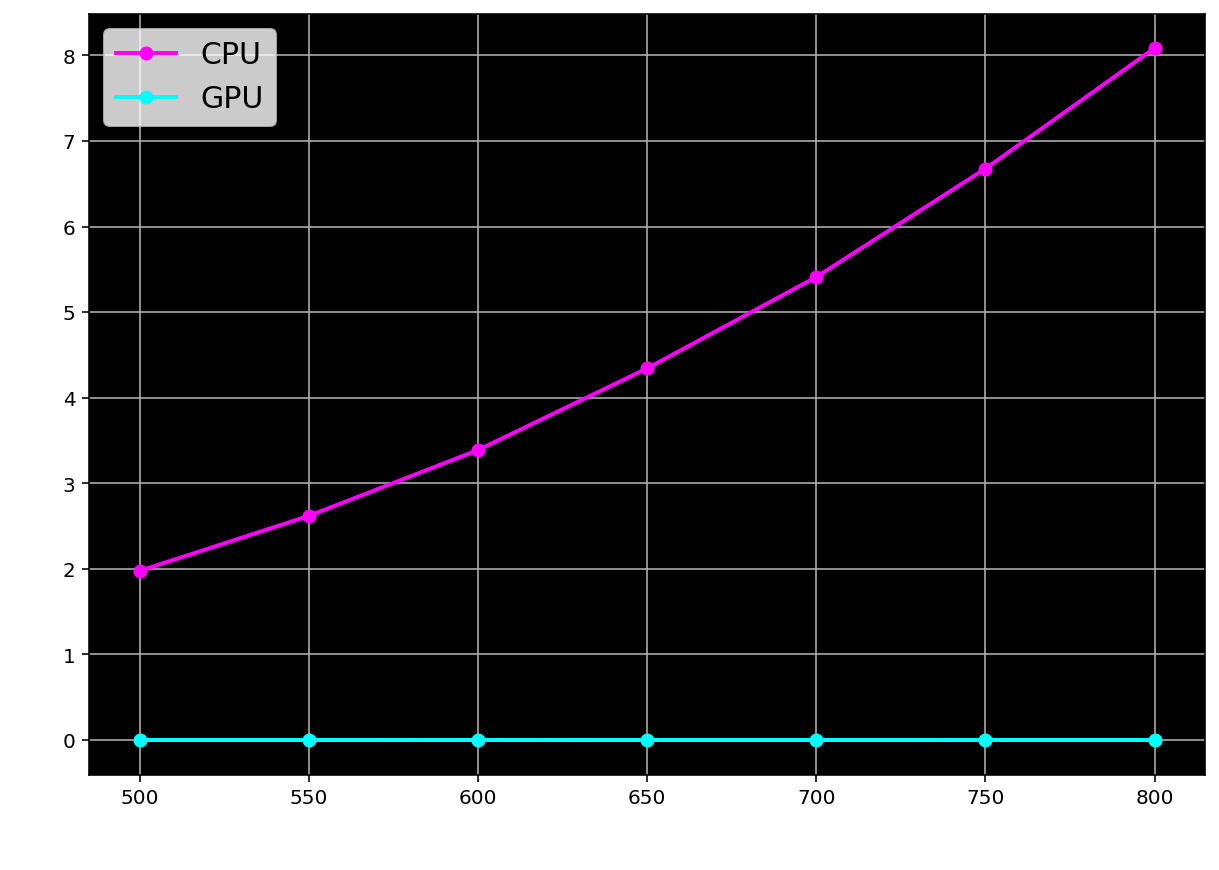

In [138]:
def plot_times(max_size = 650):
    device_times = {'/GPU:0':[], '/CPU:0':[]}
    matrix_sizes = range(450, max_size, 50)
    len_matrix = len(matrix_sizes)

    for i, size in enumerate(matrix_sizes):
        for device_name in device_times.keys():
            with tf.device(device_name):
                m1 = tf.random.uniform(shape=(size,size), dtype=tf.float16)
                m2 = tf.random.uniform(shape=(size,size), dtype=tf.float16)
                start_time = time.time()
                dot_operation = tf.matmul(m2, m1)
                time_taken = time.time() - start_time
                
                if i > 0:
                    device_times[device_name].append(time_taken)
                    
        percent_complete = (i + 1) / len_matrix
        print('\rPerforming Calculations. Please Wait... {:.0%} Complete'.format(percent_complete), end = '')
    
    matrix_sizes = matrix_sizes[1:]
    
    plt.figure(figsize=(10,7))
    
    plt.plot(matrix_sizes, device_times['/CPU:0'], 'o-', color='magenta', linewidth = 2, label = 'CPU')
    plt.plot(matrix_sizes, device_times['/GPU:0'], 'o-', color='cyan', linewidth = 2, label='GPU')
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()
    plt.ylabel('Time (s)', color='white', fontsize = 20)
    plt.xlabel('Matrix size',  color='white', fontsize = 20)
    plt.legend(prop={'size': 15})
    plt.show()
    
plot_times(850)

In [123]:
# ## Solution
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# EPOCHS = 2

# history = model.fit(training_batches,
#                     epochs=EPOCHS,
#                     validation_data=validation_batches)



# Using early stopping will terminate the training process if the validation
# loss is not improving for 5 continues epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

checkpointer = ModelCheckpoint(filepath='model.weights.best.siamese.hdf5', verbose=1, 
                               save_best_only=True)

history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    callbacks=[early_stopping, checkpointer],
    epochs=2
)



NameError: ignored

# Check Predictions

In [ ]:
# for image_batch, label_batch in testing_batches.take(1):
#     ps = model.predict(image_batch)
#     images = image_batch.numpy().squeeze()
#     labels = label_batch.numpy()

# plt.figure(figsize=(10,15))

# for n in range(30):
#     plt.subplot(6,5,n+1)
#     plt.imshow(images[n], cmap = plt.cm.binary)
#     color = 'green' if np.argmax(ps[n]) == labels[n] else 'red'
#     plt.title(class_names[np.argmax(ps[n])], color=color)
#     plt.axis('off')